In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed 
from numba import jit

from sklearn.linear_model import LinearRegression
import scipy.linalg
from sklearn import linear_model
import sklearn.linear_model as skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from PIL import Image

from imageio import imread

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [90]:
# Define the Franke Fumction
def frankeFunction(x1,x2,sig2):
    noise = np.random.normal(0,sig2,x1.shape)
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints(n, sig2):
    x1 = np.arange(0, 1, 1/n)
    x2 = np.arange(0, 1, 1/n)
    x1_d, x2_d = np.meshgrid(x1,x2)
    y_d = frankeFunction(x1_d,x2_d,sig2)
    return x1_d, x2_d, y_d.ravel()

def computeFrankeValues(x_data, y) :    
    N = x_data.shape[0]
    for i in range(N) :
        y[i] = frankeFunction(x_data[i,0], x_data[i,1],0)

def plotFranke(XX,YY,n, method):
    M = 100
    x_data = np.vstack([XX.ravel(), YY.ravel()]).T
    yy_data = np.zeros(shape=(x_data.data.shape[0]))
    computeFrankeValues(x_data, yy_data)
    
    X1 = createDesignMatrix(XX,YY,2)
    X2 = createDesignMatrix(XX,YY,3)
    X3 = createDesignMatrix(XX,YY,4)
    X4 = createDesignMatrix(XX,YY,5)
    
    z_tilde1 = predict(X1,yy_data, method, n)
    z_tilde2 = predict(X2,yy_data, method, n)
    z_tilde3 = predict(X3,yy_data, method, n)
    z_tilde4 = predict(X4,yy_data, method, n)

    Z1 = np.reshape(z_tilde1.T, XX.shape)
    Z2 = np.reshape(z_tilde2.T, XX.shape)
    Z3 = np.reshape(z_tilde3.T, XX.shape)
    Z4 = np.reshape(z_tilde4.T, XX.shape)
    
    Z = np.stack((Z1, Z2, Z3, Z4))
    print(Z.shape)
    
    ZF = np.reshape(yy_data.T, XX.shape)
    
    fig = plt.figure(figsize=(14,14))
    
    for i in range(1,5):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        surf = ax.plot_surface(XX, YY, Z[i-1].squeeze(), cmap=cm.coolwarm,
                                linewidth=0, antialiased=False)
        ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(5))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        ax.view_init(10, 45)
        ax.set_title("p = %s" %(i+1))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.savefig(f'frankePlots{method}.png')
    plt.show()
    #    return XX,YY,Z,ZF

    
# Create the design matrix with all possible combinations
@jit
def createDesignMatrix(x1, x2, n=4):
    if len(x1.shape) > 1:
        x1 = np.ravel(x1)
        x2 = np.ravel(x2)

    N = len(x1)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x1**(i-j))*(x2**j)
    return X

# Predict the outcome using matrix inversion
def predict(X, y_data, method, lmb=4):
    if method == 'OLS':
        beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_data)
        y_tilde = X @ beta
        return y_tilde
    if method == 'Ridge':
        N = np.size(X,1)
        I = np.eye(N)
        beta_ridge = np.linalg.inv(X.T @ X + lmb*I) @ X.T @ y_data
        y_tilde = X @ beta_ridge
        return y_tilde
    if method == 'Lasso':
        clf_lasso = skl.Lasso(alpha=lmb).fit(X,y_data)
        y_tilde = clf_lasso.predict(X)
        return y_tilde
        
# Calculate the mean square error (MSE)
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(y_data, y_model):
    n = np.size(y_data)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-(np.sum(y_data)/n))**2)

#Scale the data and split them for training and testing
def Scale(X_train, X_test):
    XX = np.copy(X_test)
    if X_train.shape[1] > 1:
        scaler = StandardScaler()
        scaler.fit(X_train[:,1:])
        X_train[:,1:] = scaler.transform(X_train[:,1:])
        XX[:,1:] = scaler.transform(XX[:,1:])  
    return X_train, XX#, y_train[:, np.newaxis], y_test[:, np.newaxis]

# Calculate the confidence interval of parameters Beta's
def CIBeta(X, Beta):
    varBeta = np.diagonal(np.linalg.pinv(X.T @ X)*sig2)
    stdBeta = np.sqrt(varBeta)
    errorBeta = 1.645*stdBeta
    
    # Print an example of a confidence interval
#     print(f"\nThe 90% confidence interval for beta_2 is {beta[2]-errorBeta[2]} ⟷ {beta[2]+errorBeta[2]}")

    # Plot the Confidence Intervals for the betas
    ax1 = plt.figure()
    plt.errorbar(np.arange(len(Beta)), Beta, errorBeta, fmt='cx', capsize=4, label=r"$\beta_j \pm 1.645 \sigma$")
    plt.xlabel("index $j$")
    plt.ylabel(r"$\beta_j $")
    ax1.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(0.9, 0.9))

# I cannot get this function to work with X_train
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    S = np.diag(s)
    UT = np.transpose(U)
    V = np.transpose(VT)
    invS = np.linalg.inv(S)
    #print(np.matmul(V,np.matmul(invD,UT)).shape)
    return np.matmul(V,np.matmul(invS,UT))
  
def olsRegression(X_train,X_test,y_train,y_test, plot):
    
    beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    y_tilde = (X_train @ beta)
    y_pred = (X_test @ beta)

    if plot:
        ax0 = plt.figure(0)
        plt.plot(y_tilde[:10], label="y_tilde", color="red")
        plt.scatter(np.arange(10), y_train[:10], label="y_train", color="red")

        plt.plot(y_pred[:10], label="y_pred", color="green")
        plt.scatter(np.arange(10), y_test[:10], label="y_test", color='green')
        ax0.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.1, 0.9))


    print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
    print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
    print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
    print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")
    return beta, y_pred

def ridgeRegression(X_train,X_test,y_train, y_test, nlambdas, plot):   
    N = np.size(X_train,1)
    I = np.eye(N)
    
    y_predict = np.zeros((nlambdas, X_test.shape[0]))
    y_ridgeSKL = np.zeros((nlambdas, X_test.shape[0]))

    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Ridge
        clf_ridge = skl.Ridge(alpha=lmb, fit_intercept=False).fit(X_train,y_train)
        beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
        # Make predictions
        y_tilde = X_train @ beta_ridge
        y_predict[i, :] = (X_test @ beta_ridge).squeeze()
        y_ridgeSKL[i, :] = clf_ridge.predict(X_test).squeeze()
        MSEPredict[i] = MSE(y_test, y_predict[i, :])
        MSETrain[i] = MSE(y_train, y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_ridgeSKL[i, :])
        if plot:
            CIBeta(X_train, beta_ridge)
            
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Ridge train')
        plt.plot(np.log10(lambdas), MSEPredict, 'r--', label = 'MSE Ridge Test')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Ridge sickit-learn Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')
    return  y_predict 

def lassoRegression(X_train,X_test,y_train, y_test, nlambdas, plot):

    y_pred = np.zeros((nlambdas, X_test.shape[0]))

    MSETrain = np.zeros(nlambdas)
    MSEPredictSKL = np.zeros(nlambdas)
    lambdas = np.logspace(-4,1, nlambdas)
    for i in range(nlambdas):
        lmb = lambdas[i]
        # Add Lasso
        clf_lasso = skl.Lasso(alpha=lmb, fit_intercept=False).fit(X_train,y_train)
        # Make predictions
        y_tilde = clf_lasso.predict(X_train).squeeze()
        y_pred[i, :] = clf_lasso.predict(X_test).squeeze()
        MSETrain[i] = MSE(y_train.squeeze(), y_tilde)
        MSEPredictSKL[i] = MSE(y_test, y_pred[i, :])
        
        if plot:
            CIBeta(X_train, clf_lasso.coef_)
    if plot:
        plt.figure()
        plt.plot(np.log10(lambdas), MSETrain, label = 'MSE Lasso train')
        plt.plot(np.log10(lambdas), MSEPredictSKL, 'g--', label = 'MSE Lasso Test')
        plt.xlabel('log10(lambda)')
        plt.ylabel('MSE')
        plt.legend()
        plt.title(f'# Lambdas = {nlambdas}')

    return  y_pred


def BootStrapping(method, x, y, nlambdas, maxdegree, n_boostraps):
    # Define empty arrays
    error = np.zeros((maxdegree+1, nlambdas))
    bias = np.zeros((maxdegree+1, nlambdas))
    variance = np.zeros((maxdegree+1, nlambdas))
    polydegree = np.zeros( maxdegree+1)

    if method == "ridge":
        LinReg = ridgeRegression
    elif method == "lasso":
        LinReg = lassoRegression
    for degree in range(maxdegree+1):
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  

        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]

        y_pred = np.empty((nlambdas, y_test.shape[0], n_boostraps))

        for i in range(n_boostraps):
            x_, y_ = resample(X_train, y_train)

            x_, X_test2 = Scale(x_, X_test)
            
            
            y_pred[:, :, i] = LinReg(x_, X_test2,y_train,y_test, nlambdas, plot=False)

        polydegree[degree] = degree
        error[degree, :] = np.mean(np.mean((y_test - y_pred)**2, axis=1, keepdims=True), axis=2).squeeze()
        bias[degree, :] = np.mean( (y_test - np.mean(y_pred, axis=2, keepdims=True))**2, axis=1).squeeze()
        variance[degree, :] = np.mean( np.var(y_pred, axis=2, keepdims=True) , axis=1).squeeze()

        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    lambdas = np.logspace(-4,1, nlambdas)

    for k in range(nlambdas):
        plt.subplot(2,2,k+1)
        plt.plot(polydegree, error[:, k], label="Error")
        plt.plot(polydegree, bias[:, k], label="bias")
        plt.plot(polydegree, variance[:, k], label="Variance")
        plt.legend()
        plt.title('lambda = %0.4f' %lambdas[k])
        plt.show()

def CrossValidation(method, X, y):

    if method == "ridge":
        LinReg = ridgeRegression
    elif method == "lasso":
        LinReg = lassoRegression
    elif method == "ols":
        LinReg = olsRegression
    K = [5,10]
    
    for k in K:

        #Split data set into k parts
        splitXData = np.array(np.split(X,k))
        splitYData = np.array(np.split(y,k))
        MSErrors = np.zeros((nlambdas, k))

        s0 = splitXData.shape[0]
        s1 = splitXData.shape[1]

        y_pred = np.empty((nlambdas, s1))

        for i in range(0,k):
            mask = np.ones(k)
            mask[i]=0
            X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
            X_test = splitXData[mask==0].squeeze()
            X_train, X_test = Scale(X_train, X_test)

            y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
            y_test = np.swapaxes(splitYData[mask==0], 0, 1)

            y_pred = LinReg(X_train, X_test,y_train,y_test, nlambdas, plot=False)

            MSErrors[:, i] = np.mean((y_test.squeeze() - y_pred)**2, keepdims=True, axis=1).squeeze()
        MSError = np.mean(MSErrors, axis=1)

        print("%s fold MSE:"% k, MSError)
    return y_pred

a) OLS

<ipython-input-87-17b0b635f95c>:71: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "createDesignMatrix" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'x2.2', defined at <ipython-input-87-17b0b635f95c> (83)

File "<ipython-input-87-17b0b635f95c>", line 83:
def createDesignMatrix(x1, x2, n=4):
    <source elided>
        q = int(i*(i+1)/2)
        for j in range(i+1):
        ^

During: typing of assignment at <ipython-input-87-17b0b635f95c> (83)

File "<ipython-input-87-17b0b635f95c>", line 83:
def createDesignMatrix(x1, x2, n=4):
    <source elided>
        q = int(i*(i+1)/2)
        for j in range(i+1):
        ^

  @jit
<ipython-input-87-17b0b635f95c>:71: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "createDesignMatrix" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

Fil

(4, 10, 10)


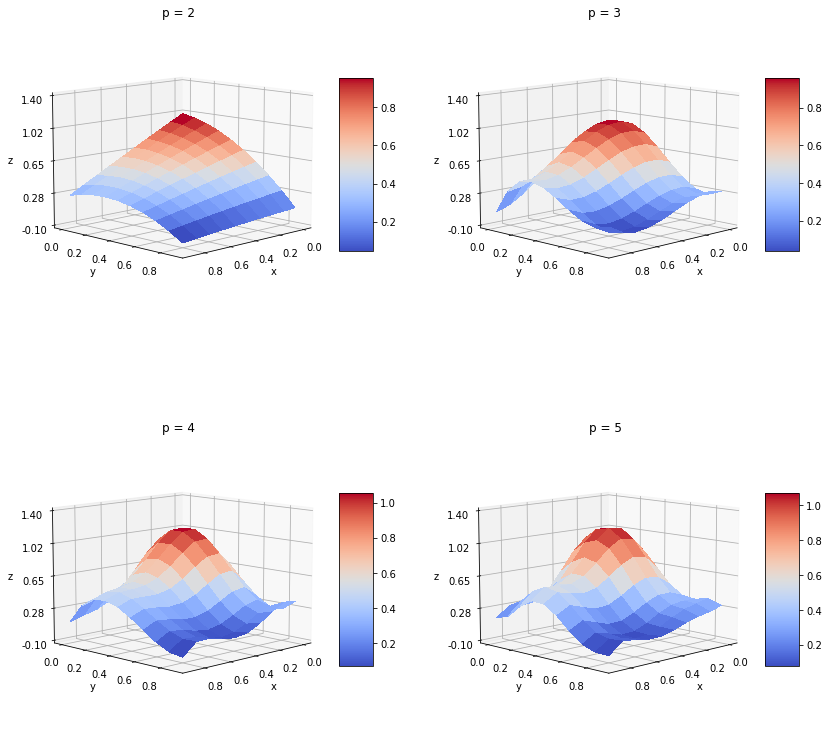

(10, 10)
(100,)
The R2 value for a polynomial of order 4, OLS test: 0.5381553185781238
The MSE value for a polynomial of order 4, OLS test: 0.021207896421225097

The R2 value for a polynomial of order 4, OLS train: 0.922016507088329
The MSE value for a polynomial of order 4, OLS train: 0.008066140753653455


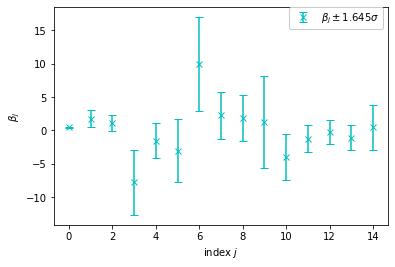

In [88]:
np.random.seed(2020)

sig2 = 0.1 # noise variance
degree = 4 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
plotFranke(x1,x2,5,'OLS')
print(x1.shape)
print(y.shape)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta, _ = olsRegression(X_train, X_test, y_train, y_test, False)

# Calculate the confidence interval of the 'p' parameters beta
CIBeta(X_train, beta)

b)

Polynomial degree: 0
Error: 0.09304829270052933
Bias^2: 0.09204223755982804
Var: 0.001006055140701291
0.09304829270052933 >= 0.09204223755982804 + 0.001006055140701291 = 0.09304829270052933

Polynomial degree: 1
Error: 0.038339460303301216
Bias^2: 0.037013985755732975
Var: 0.0013254745475682573
0.038339460303301216 >= 0.037013985755732975 + 0.0013254745475682573 = 0.03833946030330123

Polynomial degree: 2
Error: 0.02499229777465326
Bias^2: 0.022727349793554476
Var: 0.0022649479810987797
0.02499229777465326 >= 0.022727349793554476 + 0.0022649479810987797 = 0.024992297774653255

Polynomial degree: 3
Error: 0.014563528506379252
Bias^2: 0.01220963074962925
Var: 0.002353897756750002
0.014563528506379252 >= 0.01220963074962925 + 0.002353897756750002 = 0.014563528506379252

Polynomial degree: 4
Error: 0.015617868631644053
Bias^2: 0.008199919525022263
Var: 0.007417949106621792
0.015617868631644053 >= 0.008199919525022263 + 0.007417949106621792 = 0.015617868631644057

Polynomial degree: 5
Error

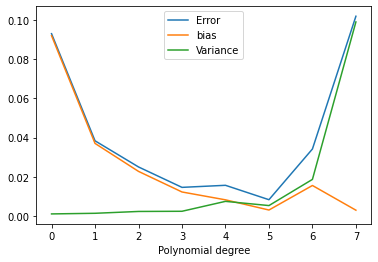

In [14]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 7 # maximum polynomial degree

for n in range(10,11):
#     print(n)
    # Make data set.
    x1, x2, y = createDataPoints(n, sig2)
    x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)
#     print(x.shape)

    # Define empty arrays
    error = np.zeros(maxdegree+1)
    bias = np.zeros(maxdegree+1)
    variance = np.zeros(maxdegree+1)
    polydegree = np.zeros(maxdegree+1)


    for degree in range(maxdegree+1):
#         print("\n", degree, "\n")
        X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
        
        # Split and scale the design data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        y_train, y_test = y_train[:, np.newaxis], y_test[:, np.newaxis]
#         X_test.flags.writeable = False
        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
#             print(i)
            x_, y_ = resample(X_train, y_train)
#             print("X_test before", X_test[:1, :])

            x_, X_test2 = Scale(x_, X_test)
#             print("X_test after", X_test2[:1, :])

            beta = np.linalg.pinv(x_.T.dot(x_)).dot(x_.T).dot(y_)
            y_pred[:, i] = (X_test2 @ beta).squeeze()

        polydegree[degree] = degree
        error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        print("Polynomial degree:", degree)
        print("Error:", error[degree])
        print("Bias^2:", bias[degree])
        print("Var:", variance[degree])
        print('{} >= {} + {} = {}\n'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

    plt.plot(polydegree, error, label="Error")
    plt.plot(polydegree, bias, label="bias")
    plt.plot(polydegree, variance, label="Variance")
    plt.xlabel('Polynomial degree')
    plt.legend()
    plt.savefig('partBplot.jpg')
    plt.show()

c) Cross validation

In [15]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

for k in K:

    #Split data set into k parts
    splitXData = np.array(np.split(X,k))
    splitYData = np.array(np.split(y,k))
    MSErrors = np.zeros(k)

    s0 = splitXData.shape[0]
    s1 = splitXData.shape[1]

    for i in range(0,k):
        mask = np.ones(k)
        mask[i]=0
        X_train = splitXData[mask==1].reshape(((s0-1)*s1,-1))
        X_test = splitXData[mask==0].squeeze()
        X_train, X_test = Scale(X_train, X_test)

        y_train = splitYData[mask==1].reshape(((s0-1)*s1,1))
        y_test = np.swapaxes(splitYData[mask==0], 0, 1)

        beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
        y_pred = (X_test @ beta)

        MSErrors[i] = np.mean((y_test - y_pred)**2, keepdims=True)
    MSError = np.mean(MSErrors)

    print("%s fold MSE:"% k, MSError)

Polynomial degree: 7
5 fold MSE: 0.0033216318833721213
10 fold MSE: 0.0020835870696384617


Compare our code for k-CV with that from scikit-learn

In [16]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

poly = PolynomialFeatures(degree = 7)

OLS = LinearRegression(fit_intercept=False)
X = poly.fit_transform(x)
X = X[p]
y = y[p]
estimated_mse_folds = cross_val_score(OLS, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=10)

estimated_mse_sklearn = np.mean(-estimated_mse_folds)

print(estimated_mse_sklearn)

0.0020835879224487116


d) Example of Ridge regression

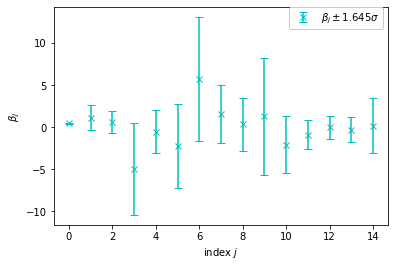

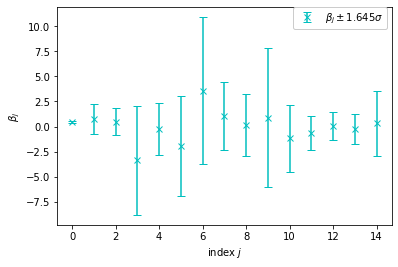

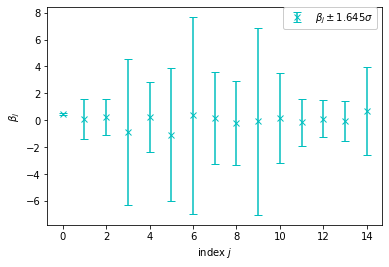

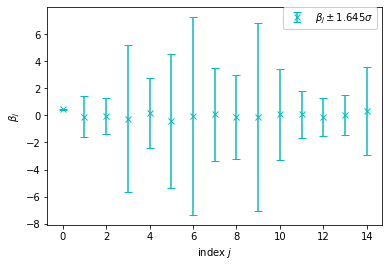

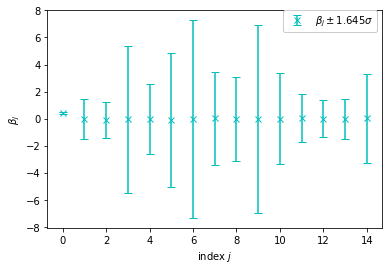

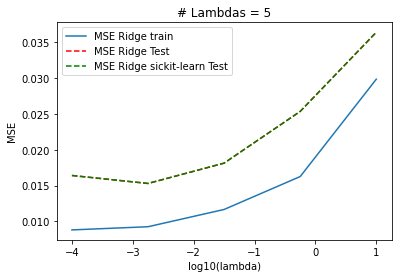

In [97]:
np.random.seed(26)

sig2 = 0.1 # noise variance
degree = 4 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = ridgeRegression(X_train, X_test,y_train,y_test, nlambdas=5, plot=True)
# CIBeta(X=X_train, Beta=beta_ridge)

d) Perform bootstrapping with ridge

Polynomial degree: 0
Error: [0.09202979 0.09202991 0.09203735 0.09533053]
Bias^2: [0.09202979 0.09202991 0.09203735 0.09533053]
Var: [0. 0. 0. 0.]
[0.09202979 0.09202991 0.09203735 0.09533053] >= [0.09202979 0.09202991 0.09203735 0.09533053] + [0. 0. 0. 0.] = [0.09202979 0.09202991 0.09203735 0.09533053]

Polynomial degree: 1
Error: [0.07982476 0.07982547 0.07986013 0.08426419]
Bias^2: [0.07662241 0.07662358 0.07667933 0.08186883]
Var: [0.00320235 0.0032019  0.00318081 0.00239535]
[0.07982476 0.07982547 0.07986013 0.08426419] >= [0.07662241 0.07662358 0.07667933 0.08186883] + [0.00320235 0.0032019  0.00318081 0.00239535] = [0.07982476 0.07982547 0.07986013 0.08426419]

Polynomial degree: 2
Error: [0.09814557 0.09813625 0.09777963 0.10297877]
Bias^2: [0.09218285 0.09218558 0.09231577 0.10060253]
Var: [0.00596272 0.00595067 0.00546386 0.00237624]
[0.09814557 0.09813625 0.09777963 0.10297877] >= [0.09218285 0.09218558 0.09231577 0.10060253] + [0.00596272 0.00595067 0.00546386 0.00237624] 

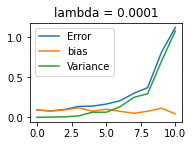

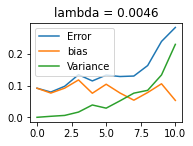

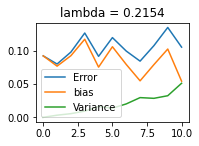

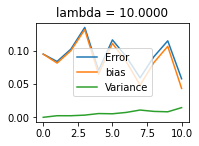

In [18]:
np.random.seed(26)
# print(np.random.get_state()[1][0])

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 5 # maximum polynomial degree
nlambdas = 4

# for  in range(10,11):
# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

BootStrapping("ridge", x, y, nlambdas=4, maxdegree=10, n_boostraps=200)

d) Perform cross validation on ridge regression

In [21]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

_ = CrossValidation("ridge", X,y)

Polynomial degree: 7
5 fold MSE: [0.00396176 0.00575206 0.0097047  0.02142667]
10 fold MSE: [0.00364082 0.00385706 0.00920423 0.02012492]


e) Example of Lasso regression

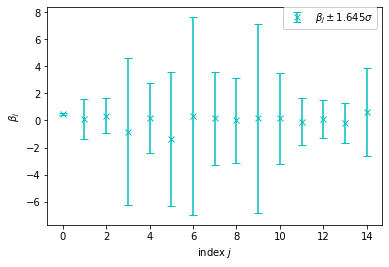

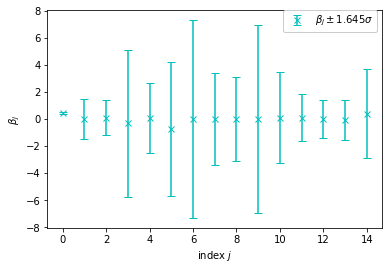

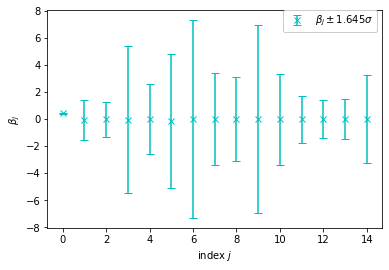

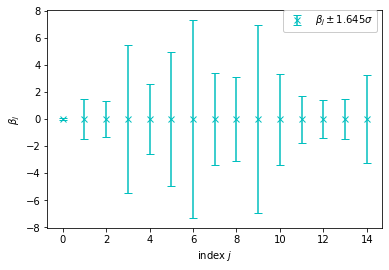

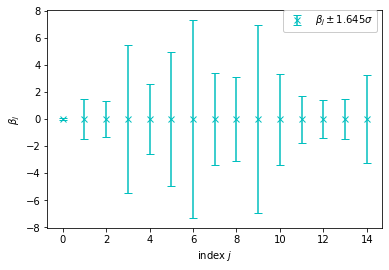

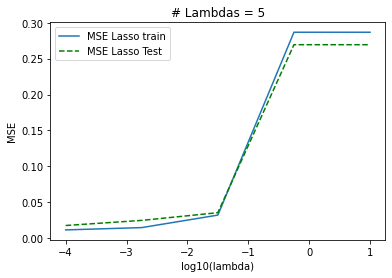

In [96]:
np.random.seed(26)

sig2 = 0.1 # noise variance
degree = 4 # polynomial degree
n = 10 # number of data points for each feature
x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = lassoRegression(X_train, X_test,y_train, y_test, nlambdas=5, plot=True)
# CIBeta(X=X_train, Beta=beta_lasso)

e) Performing bootstrapping with lasso regression

Polynomial degree: 0
Error: [0.09203022 0.09207086 0.13935235 0.29022419]
Bias^2: [0.09203022 0.09207086 0.13935235 0.29022419]
Var: [3.08148791e-33 1.23259516e-32 7.70371978e-34 0.00000000e+00]
[0.09203022 0.09207086 0.13935235 0.29022419] >= [0.09203022 0.09207086 0.13935235 0.29022419] + [3.08148791e-33 1.23259516e-32 7.70371978e-34 0.00000000e+00] = [0.09203022 0.09207086 0.13935235 0.29022419]

Polynomial degree: 1
Error: [0.07956393 0.07867166 0.09855727 0.23572091]
Bias^2: [0.07705547 0.07669647 0.09855727 0.23572091]
Var: [0.00250847 0.00197519 0.         0.        ]
[0.07956393 0.07867166 0.09855727 0.23572091] >= [0.07705547 0.07669647 0.09855727 0.23572091] + [0.00250847 0.00197519 0.         0.        ] = [0.07956393 0.07867166 0.09855727 0.23572091]

Polynomial degree: 2
Error: [0.09123359 0.0877047  0.15035371 0.30879218]
Bias^2: [0.08428847 0.08455834 0.15035371 0.30879218]
Var: [6.94511579e-03 3.14635538e-03 3.08148791e-33 0.00000000e+00]
[0.09123359 0.0877047  0.150353

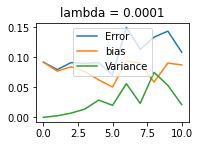

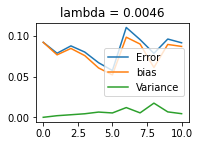

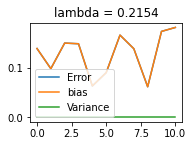

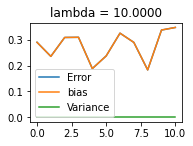

In [92]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
n_boostraps = 200 # number of bootstraps 
maxdegree = 10 # maximum polynomial degree
nlambdas = 4

# Make data set.
x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

BootStrapping("lasso", x, y, nlambdas=4, maxdegree=10, n_boostraps=200)

e) Perform cross validation on lasso regression

In [25]:
np.random.seed(26)

sig2 = 0.01 # noise variance
n = 10 # number of data points for each feature
K = [5, 10]
degree = 7
nlambdas = 4

x1, x2, y = createDataPoints(n, sig2)
x = np.swapaxes(np.stack((x1.ravel(),x2.ravel())),0,1)

X = createDesignMatrix(x[:,[0]],x[:,[1]],degree)  
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Polynomial degree:", degree)

_ = CrossValidation("ridge", X,y)

Polynomial degree: 7
5 fold MSE: [0.00396176 0.00575206 0.0097047  0.02142667]
10 fold MSE: [0.00364082 0.00385706 0.00920423 0.02012492]


f) Import and plot the terrain data

(3601, 1801)


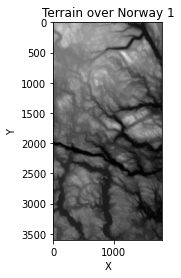

In [100]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

print(terrain1.shape)
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('terrain2dplot.png')
plt.show()

In [99]:
# np.random.seed(2020)

newLength = 500
x1 = np.linspace(0,5,np.int(newLength/2))
x2 = np.linspace(0,10,newLength)
x1, x2 = np.meshgrid(x1,x2)
print(x1.shape)

primStep = np.floor(1/newLength*3601).astype(int)
print("prim ", primStep)
secoStep = np.floor(1/np.int(newLength/2)*1801).astype(int)
print("seco ", secoStep)

term1 = primStep*x1.shape[0]
term2 = secoStep*x1.shape[1]

print(term1)
ter = terrain1[1:term1:primStep, 1:term2:secoStep]
print("ter", ter.shape)
y = ter.ravel()
print(y.shape)
degree = 5
X = createDesignMatrix(x1,x2,degree)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

beta = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
y_tilde = (X_train @ beta)
y_pred = (X_test @ beta)

scaler = StandardScaler()
scaler.fit(X[:,1:])
X[:,1:] = scaler.transform(X[:,1:])

beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
y_new = (X @ beta)
print(y_new.shape)
plt.figure()
plt.imshow(y_new.reshape(newLength,(np.int(newLength/2))), cmap='gray')
plt.figure()
plt.imshow(ter.reshape((newLength,np.int(newLength/2))), cmap='gray')
print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")

(500, 250)
prim  7
seco  7
3500


NameError: name 'terrain1' is not defined

y (40000,)
The R2 value for a polynomial of order 25, OLS test: 0.9800566543661149
The MSE value for a polynomial of order 25, OLS test: 456.72575624993027

The R2 value for a polynomial of order 25, OLS train: 0.9800730055314042
The MSE value for a polynomial of order 25, OLS train: 456.85774524838604
4.1175951537297807e-16
0.9999999999999672
OLS (40000,)
Rid (40000,)
Las (40000,)


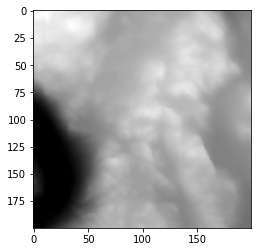

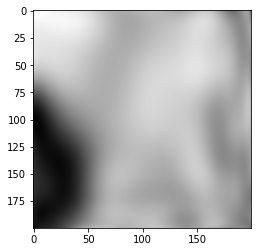

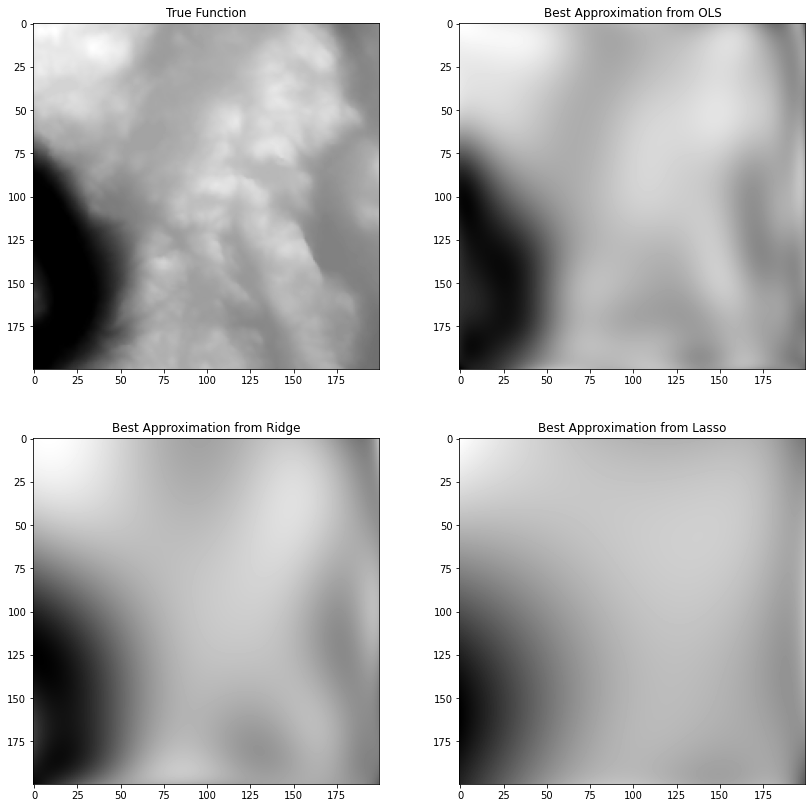

In [118]:
# np.random.seed(2020)

newLength = 200
startingPoint = 100
x1 = np.linspace(0,1,newLength)
x2 = np.linspace(0,1,newLength)
x1, x2 = np.meshgrid(x1,x2)

croppedTerrain = terrain1[startingPoint:newLength+startingPoint, startingPoint:newLength+startingPoint]
y = croppedTerrain.ravel()

print("y", y.shape)

degree = 25
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train, X_test = Scale(X_train, X_test)

_ = olsRegression(X_train, X_test, y_train,y_test, False)

scaler = StandardScaler()
scaler.fit(X[:,1:])
X[:,1:] = scaler.transform(X[:,1:])
print(np.mean(X[:,1]))
print(np.var(X[:,1]))

beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
y_OLS = (X @ beta)
print("OLS", y_OLS.shape)

clf_ridge = skl.Ridge(alpha=0.1, fit_intercept=False).fit(X,y)
y_Ridge = clf_ridge.predict(X).squeeze()
print("Rid", y_Ridge.shape)

clf_lasso = skl.Lasso(alpha=0.1, fit_intercept=False).fit(X,y)
y_Lasso = clf_lasso.predict(X).squeeze()
print("Las", y_Lasso.shape)

plt.figure()
plt.imshow(croppedTerrain, cmap='gray')

plt.figure()
plt.imshow(y_OLS.reshape(newLength,newLength), cmap='gray')

Y = np.stack((y, y_OLS, y_Ridge, y_Lasso))
name = ["True Function", "Best Approximation from OLS", "Best Approximation from Ridge", "Best Approximation from Lasso"]


fig = plt.figure(figsize=(14,14))

for i in range(1,5):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    surf = ax.plot_surface(x1, x2, Y[i-1].reshape(newLength,newLength), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(5))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.view_init(10, 45)
    ax.set_title(name[i-1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.colorbar(surf, shrink=0.5, aspect=5)

In [29]:
newLength = 100
startingPoint = 100
x1 = np.linspace(0,1,newLength)
x2 = np.linspace(0,1,newLength)
x1, x2 = np.meshgrid(x1,x2)
K = [5, 10]
nlambdas = 4


croppedTerrain = terrain1[startingPoint:newLength+startingPoint, startingPoint:newLength+startingPoint]
y = croppedTerrain.ravel()

degree = 25
X = createDesignMatrix(x1,x2,degree)

# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
# X_train, X_test = Scale(X_train, X_test)
p = np.random.permutation(X.shape[0])
X = X[p]
y = y[p]

print("Cross validation with ridge:")
_ = CrossValidation("ridge", X, y)

print("Cross validation with lasso:")
_ = CrossValidation("lasso", X, y)

Cross validation with ridge:
5 fold MSE: [139.80343469 193.20376542 279.06888047 432.69451251]
10 fold MSE: [138.25409766 190.89486616 276.25174956 427.03216083]
Cross validation with lasso:
5 fold MSE: [ 432.09318963  429.41504186  594.19616465 4312.85328623]
10 fold MSE: [ 432.61100882  429.87494295  594.73616079 4317.24401555]
